In [1]:
!pip install transformers

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from matplotlib import pyplot
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
from nltk import word_tokenize
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def preprocess_pandas(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data['tweet'] = data['tweet'].str.lower()
    data['tweet'] = data['tweet'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['tweet'] = data['tweet'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['tweet'] = data['tweet'].replace('@[a-zA-Z0-9-_]+', '@USER', regex=True)                                     # remove usernames
    data['tweet'] = data['tweet'].replace('https:\/\/t\.co\/[a-zA-Z0-9]+', '', regex=True)                       # remove specific links
    data['tweet'] = data['tweet'].str.replace('[^\w\s]','')                                                      # remove special characters
    data['tweet'] = data['tweet'].replace('\d', '', regex=True)          
    data['tweet'] = '[CLS] ' + data['tweet'] + ' [SEP]'                    
# remove numbers
    for index, row in data.iterrows():
        #filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
        df_ = df_.append({
            "index": row['id'],
            "class": row['subtask_a'],
            "tweet": row['tweet']
        }, ignore_index=True)
    return data

In [ ]:

# If this is the primary file that is executed (ie not an import of another file)
if __name__ == "__main__":
    # get data, pre-process and split
    data = pd.read_csv("/kaggle/input/hasoc-2019/english_dataset.tsv", delimiter='\t', header=None)
    data.columns = ['id','tweet', 'task_1', 'task_2', 'task_3']
    data['index'] = data.index                                          # add new column index
    columns = ['id', 'task_2', 'tweet']
    data = preprocess_pandas(data, columns)        # pre-process
    data = data.drop(0)                     
    training_data, validation_data, training_labels, validation_labels = train_test_split( # split the data into training, validation, and test splits
        data['tweet'].values.astype('U'),
        data['task_2'].values.astype('U'),
        test_size=0.10,
        random_state=0,
        shuffle=True
    )
    test_data = pd.read_csv("/kaggle/input/hasoc-2019/hasoc2019_en_test-2919.tsv", delimiter = '\t', header = None)
    test_data.columns = ['id', 'tweet', 'task_1', 'task_2', 'task_3']
    test_data['index'] = test_data.index
    test_data = preprocess_pandas(test_data, columns)
    test_data = test_data.drop(0)

    




In [8]:
olid_data = pd.read_csv("/kaggle/input/olid-data/OLID_Tain_ATUSER_URL_EmojiRemoved_Pedro.txt", delimiter = '\t', header = None)
olid_data.columns = ['id', 'tweet', 'subtask_a', 'subtask_b', 'subtask_c']
olid_data['index'] = olid_data.index
columns = ['id', 'tweet', 'subtask_a']
olid_data = preprocess_pandas(olid_data, columns)
olid_data = olid_data.drop(0)

olid_data = olid_data.fillna('NONE')

train_data, test_data, train_labels, test_labels = train_test_split( # split the data into training, validation, and test splits
    olid_data['tweet'].values.astype('U'),
    olid_data['subtask_a'].values.astype('U'),
    test_size=0.10,
    random_state=0,
    shuffle=True
    )

In [ ]:
print(data['task_2'].value_counts())
print(test_data['task_2'].value_counts())

In [9]:
from transformers import AutoModel, AutoTokenizer
bertweet = AutoModel.from_pretrained("vinai/bertweet-base")

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
import torch
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Dense
from keras.utils import to_categorical
from torch.nn.utils.rnn import pad_sequence

labels_map = {
    "NONE" : 0,
    "HATE" : 1,
    "PRFN" : 2,
    "OFFN" : 3
}

olid_labels_map = {
    "NONE" : 0,
    "UNT" : 1,
    "TIN" : 2
}
olid_labels_map2 = {
    "OFF" : 0,
    "NOT" : 1
}

bertweet = bertweet.to(device)
word_embeddings = []
test_embeddings = []
labels = []
test_labels = []

In [16]:


#OLID
for n in olid_data.iloc():
    input_ids = torch.tensor([tokenizer.encode(n["tweet"])]).to(device)
    with torch.no_grad():
      if(input_ids.shape[1] < 128):
        features = bertweet(input_ids)  # Models outputs are now tuples
        cls_features = features[-1][0,:].cpu()  # Take the [CLS] features and move to CPU
        word_embeddings.append(cls_features)
        labels.append(olid_labels_map2[n['subtask_a']])





In [ ]:
#HASOC
for n in data.iloc():
    input_ids = torch.tensor([tokenizer.encode(n["tweet"])]).to(device)
    with torch.no_grad():
      if(input_ids.shape[1] < 128):
        features = bertweet(input_ids)  # Models outputs are now tuples
        cls_features = features[-1][0,:].cpu()  # Take the [CLS] features and move to CPU
        word_embeddings.append(cls_features)
        labels.append(labels_map[n['task_2']])

for n in test_data.iloc():
    input_ids = torch.tensor([tokenizer.encode(n["tweet"])]).to(device)
    with torch.no_grad():
      if(input_ids.shape[1] < 128):
        features = bertweet(input_ids)  # Models outputs are now tuples
        cls_features = features[-1][0,:].cpu()  # Take the [CLS] features and move to CPU
        test_embeddings.append(cls_features)
        test_labels.append(labels_map[n['task_2']])

In [ ]:
len(word_embeddings[2])

In [19]:
# Convert to Torch tensors
import torch
import torch.nn.functional as F

#print(word_embeddings.shape)
#word_embeddings = F.pad(word_embeddings, pad=(0, 0, 0, 100 - word_embeddings.shape[1]))

from torch.nn.utils.rnn import pad_sequence


X = torch.stack(word_embeddings)
#X_test = torch.stack(test_embeddings)
y = torch.tensor(labels)
#y_test = torch.tensor(test_labels)

dataset = TensorDataset(X, y)
#testData = TensorDataset(X_test, y_test)

train_size = int(0.85 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = int(0.1 * len(dataset)) 

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(12392))
# Creating dataloader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = True)

# Assuming the shape of an individual embedding is (sequence_length, embedding_dim)

# Number of classes
num_classes = len(labels_map)


In [32]:
from torch.autograd import Variable 
from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import StepLR

class CNN(nn.Module):
    def __init__(self, embedding_dim, num_classes, hidden_size, num_layers):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(embedding_dim, 668, kernel_size=1, stride=1)
        self.conv2 = nn.Conv1d(668,568,1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.bn2 = nn.BatchNorm1d(360)
        self.lstm = nn.LSTM(568, hidden_size, num_layers, batch_first=True, bidirectional = True) # LSTM layer
        self.fc_1 =  nn.Linear(2*hidden_size, hidden_size) #fFirst FC layer
        self.fc = nn.Linear(hidden_size, num_classes) # Final FC layer

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, x.size(2))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool1d(x,x.size(2)).squeeze(2)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        X = self.fc2(x)
        return F.log_softmax(x, dim=1)
    def forward2(self, x):
        x = x.unsqueeze(2)  # Add an extra dimension for the Conv1D
        x = torch.permute(x, (0,2,1))
        # Pass x (not x_conv) through LSTM because LSTM expects a sequence
        h_0 = Variable(torch.zeros(4, x.size(0), 400)).to(device) #hidden state
        c_0 = Variable(torch.zeros(4, x.size(0), 400)).to(device) #internal state


        # Propagate input through LSTM
        out, _ = self.lstm(x, (h_0, c_0)) # LSTM with input, hidden, and internal state
        out = out[:, -1, :] # Take the last output for classification
        out = F.relu(out)
        out = self.fc_1(out) #first Dense
        out = F.relu(out) #relu
        out = self.fc(out) #Final Output
        return out
    def forward3(self, x):
        x = x.unsqueeze(2)
  
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, x.size(2))
        #x = self.dropout(x)
        x = F.relu((self.conv2(x)))
        x = F.max_pool1d(x,x.size(2))
        #x = self.dropout(x)
        x = x.transpose(1,2)

        h_0 = Variable(torch.zeros(4, x.size(0), 400)).to(device) #hidden state
        c_0 = Variable(torch.zeros(4, x.size(0), 400)).to(device) #internal state
       
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #hn = hn.view(-1, 400) #reshaping the data for Dense layer next
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim=1)
        out = F.relu(hn)
        out = self.fc_1(out) #first Dense
        out = F.relu(out) #relu
        out = self.dropout(out)
        out = self.fc(out) #Final Output
        return out

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

  

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, scheduler, early_stopping):
    train_accuracy = 0
    total = 0
    val_loss_history = []

    for epochs in range(num_epochs):
        model.train()
        for batch_nr, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.to(device)

            prediction = model.forward3(data)
            loss = criterion(prediction, labels)

            loss.backward()

            optimizer.step()

            optimizer.zero_grad()
            
            _, predicted = torch.max(prediction, 1)
            train_accuracy += (predicted == labels).sum().item()
            total += labels.size(0)
            
        # Call scheduler.step() after each epoch, not each batch
        scheduler.step()

        val_acc = 0 
        val_total = 0
        val_loss_epoch = 0
        with torch.no_grad():
            for batch_nr, (data, labels) in enumerate(val_loader):
                data = data.to(device)
                labels = labels.to(device)
                prediction = model.forward3(data).to(device)

                val_loss = criterion(prediction, labels)

                val_loss_epoch += val_loss.item() # Keep track of the total loss for this epoch
                _, predicted = torch.max(prediction, 1)
                val_acc += (predicted == labels).sum().item()
                val_total += labels.size(0)

            val_loss_epoch = val_loss_epoch / len(val_loader) # Get the average loss for this epoch
            val_loss_history.append(val_loss_epoch) # Add to the history
            
            print(
                f'\rEpoch {epochs+1} [{batch_nr+1}/{len(train_loader)}] - Loss: {loss} - ValLoss: {val_loss_epoch}  - ValAcc: {val_acc/val_total}',
                end='')

            # Here we call early stopping
            early_stopping(val_loss_epoch, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

    return val_loss_history


 
def test_model(model, test_loader):
    # Set the model to evaluation mode
  correct = 0
  total = 0
  predlist = []
  truelist = []
  with torch.no_grad():  # No need to track gradients
    model.eval()
    for data, labels in test_loader:
      data = data.to(device)
      labels = labels.to(device)
      outputs = model.forward3(data)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      #f1 = f1_score(predicted, labels, average = 'weighted')
      for i in range(len(predicted)):
        predlist.append(predicted[i].item())
        truelist.append(labels[i].item())

  print('Test Accuracy of the model on the test set: {} %'.format(100 * correct / total))
  #print('F1-score', f1)
  return truelist, predlist




In [33]:
model = CNN(768, 2, 400, 2)
model = torch.compile(model)
model = model.to(device)
epochs = 50
LEARNING_RATE = 1e-3
# Define our loss function
weights = [1,1]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)

# Define our optimizer

optimizer = optim.Adam(model.parameters(), LEARNING_RATE)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
early_stopping = EarlyStopping(patience = 10, verbose = True)
# Train the model
trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs = epochs, scheduler = scheduler, early_stopping = early_stopping)
truelist, predlist = test_model(model, test_loader)

Epoch 1 [21/352] - Loss: 0.5147656798362732 - ValLoss: 0.5925736242816562  - ValAcc: 0.6910876132930514Validation loss decreased (inf --> 0.592574).  Saving model ...
Epoch 2 [21/352] - Loss: 0.5242037177085876 - ValLoss: 0.5507185998417082  - ValAcc: 0.7424471299093656Validation loss decreased (0.592574 --> 0.550719).  Saving model ...
Epoch 3 [21/352] - Loss: 0.4253119230270386 - ValLoss: 0.5548610744022188  - ValAcc: 0.7265861027190332EarlyStopping counter: 1 out of 10
Epoch 4 [21/352] - Loss: 0.6118273138999939 - ValLoss: 0.5372001230716705  - ValAcc: 0.736404833836858Validation loss decreased (0.550719 --> 0.537200).  Saving model ...
Epoch 5 [21/352] - Loss: 0.6221610903739929 - ValLoss: 0.5282823954309736  - ValAcc: 0.7424471299093656Validation loss decreased (0.537200 --> 0.528282).  Saving model ...
Epoch 6 [21/352] - Loss: 0.4531584680080414 - ValLoss: 0.6435825668630146  - ValAcc: 0.7190332326283988EarlyStopping counter: 1 out of 10
Epoch 7 [21/352] - Loss: 0.571407556533813

In [35]:
model.load_state_dict(torch.load('checkpoint.pt'))
truelist, predlist = test_model(model, test_loader)

Test Accuracy of the model on the test set: 78.20996978851964 %


In [23]:
import matplotlib.pyplot as plt
import numpy as np
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 516  347]
 [ 230 1555]]


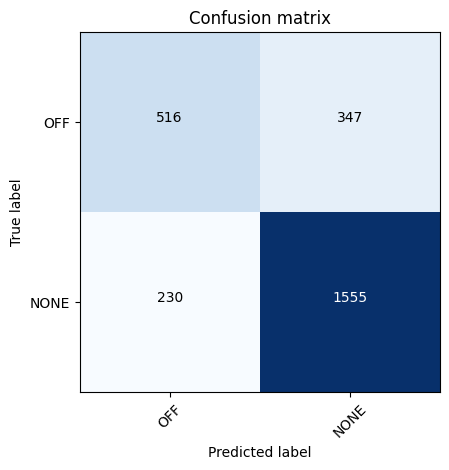

In [36]:

    cnf_matrix = confusion_matrix(truelist, predlist)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['OFF', 'NONE'])

In [ ]:
def plot_val_loss(val_loss_history):
    plt.plot(val_loss_history)
    plt.title('Model validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

# Plot validation loss
plot_val_loss(trained_model)